# Major / Mildenhall Examples

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.core.display import HTML, display
from importlib import reload
import re
import pypandoc
# pandas options 
pd.set_option('max_rows', 50)
pd.set_option('max_columns', 30)
pd.set_option('display.max_colwidth', 150)

# matplotlib and plotting options 
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# seaborn options 
sns.set(context='paper', style='darkgrid', font='serif')
# sns.set(context='paper', style='ticks', font='serif')

# warnings
import warnings
# warnings.simplefilter('error')
# warnings.simplefilter('ignore')
import logging
logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

In [2]:
# this file is in examples
from importlib import reload
import sys
sys.path.insert(0,'..')
import aggregate as agg

import aggregate.parser as parser
import aggregate.underwriter as trash

uw = trash.Underwriter(debug=False)

In [3]:
def extract_info(port, p, r):
    """
    Extract info from portfolio object port for TVaR threshold p
    """
    df = port.density_df
    bs = df.index[1]
    var = port.q(p)
    tvar = df.loc[var, 'exgta_total']
    bit1 = df.filter(regex='S|exa_').loc[tvar-bs/2:tvar+bs/2, :]
    tvar = bit1.index[0]
    bit2 = df.filter(regex='S|exgta_').loc[var, :]
    ans = pd.concat((bit1, pd.DataFrame(bit2).T), axis=0, sort=True).sort_index().fillna('')
    ans.index.name = 'a'
    ans2 = pd.DataFrame({**dict(var=var, tvar=tvar), 
                         **{'S(var)': ans.iloc[0,0], 'S(tvar)': ans.iloc[1,0]},
                         **{f'E({i}|U>var)': ans.loc[var, f'exgta_{i}'] for i in port.line_names_ex},
                         **{f'EL({i})': ans.loc[tvar, f'exa_{i}'] for i in port.line_names_ex},
                        }, index=pd.MultiIndex.from_arrays([[port.name.replace("~", ' ')], ['basic']]))
    for l in port.line_names_ex:
        el = ans2.loc[:, f'EL({l})']
        t = ans2.loc[:, f'E({l}|U>var)']
        P_basic = (r*t + el) / (1+r)
#         K_basic = t - P_basic
        ans2[f'Prem({l})'] = P_basic
#         ans2[f'K({l})'] = K_basic
        ans2[f'LR({l})'] = el / P_basic
    ans2 = ans2.T.copy()
    # now add PH and wang pricing... 
    ans3 = ans2.copy()
    for dist in ['ph', 'wang']:
        ans3.columns = pd.MultiIndex.from_arrays([[port.name.replace("~", ' ')], [dist]])
        cd = port.calibrate_distortions(ROEs=[r], As=[tvar])
        dd = agg.Distortion.distortions_from_params(cd, cd.loc[(slice(None), slice(None), dist), :].index[0][0:2], plot=False)
        ddph = {dist: dd[dist]}
        rho = dd[dist].shape
        ans_table, ans_stacked = port.apply_distortions(ddph, As=[tvar], num_plots=0)
        ans_table
        ans3.loc['distn param', :] = rho
        # strip out new prem from ans_table
        for l in port.line_names_ex:
            el = ans3.loc[f'EL({l})', :]
            P_basic = ans_table.loc[tvar, f'exag_{l}'] 
    #         K_basic = 0
            ans3.loc[f'Prem({l})', :] = P_basic
    #         ans3.loc[f'K({l})', :] = K_basic
            ans3.loc[f'LR({l})', :] = el / P_basic    
        ans2 = pd.concat((ans2, ans3), axis=1, sort=True)
    ans2.loc['r', :] = r
    ans2 = ans2.sort_index(ascending=False)
    return ans, ans2

In [4]:
def marginal_test(base_pf, ex1, ex2, dx, p, r, bs, log2, display_df, **kwargs):
    """
    does not locking in the distortion...is that correct>
    """
    pf = {}
    xx = {}
    ans = []
    for i in [0, 1, 2]:
        pf[i] = base_pf.format(i=i, ex1=ex1 + (i&1)*dx, ex2=ex2 + (i&2)*dx)
        xx[i] = uw(pf[i])
        xx[i].update(bs=bs, log2=log2, **kwargs)
        if display_df:
            display(xx[i])
        else:
            print(f'completed {i}')
        a1, a2 = extract_info(xx[i], p, r)
        a2.loc['type', :] = i
        ans.append(a2)
    return pd.concat(ans, axis=1, sort=True)

In [5]:
def extract_info_fixed(port, p, r, dd=None):
    """
    Extract info from portfolio object port for TVaR threshold p
    FIXED calibration 
    """
    df = port.density_df
    bs = df.index[1]
    var = port.q(p)
    tvar = df.loc[var, 'exgta_total']
    bit1 = df.filter(regex='S|exa_').loc[tvar-bs/2:tvar+bs/2, :]
    tvar = bit1.index[0]
    bit2 = df.filter(regex='S|exgta_').loc[var, :]
    ans = pd.concat((bit1, pd.DataFrame(bit2).T), axis=0, sort=True).sort_index().fillna('')
    ans.index.name = 'a'
    ans2 = pd.DataFrame({**dict(var=var, tvar=tvar), 
                         **{'S(var)': ans.iloc[0,0], 'S(tvar)': ans.iloc[1,0]},
                         **{f'E({i}|U>var)': ans.loc[var, f'exgta_{i}'] for i in port.line_names_ex},
                         **{f'EL({i})': ans.loc[tvar, f'exa_{i}'] for i in port.line_names_ex},
                        }, index=pd.MultiIndex.from_arrays([[port.name.replace("~", ' ')], ['basic']]))
    for l in port.line_names_ex:
        el = ans2.loc[:, f'EL({l})']
        t = ans2.loc[:, f'E({l}|U>var)']
        P_basic = (r*t + el) / (1+r)
#         K_basic = t - P_basic
        ans2[f'Prem({l})'] = P_basic
#         ans2[f'K({l})'] = K_basic
        ans2[f'LR({l})'] = el / P_basic
    ans2 = ans2.T.copy()
    # now add PH and wang pricing... 
    ans3 = ans2.copy()
    for dist in ['ph', 'wang']:
        ans3.columns = pd.MultiIndex.from_arrays([[port.name.replace("~", ' ')], [dist]])
        if dd is None:
            # recalibrate
            cd = port.calibrate_distortions(ROEs=[r], As=[tvar])
            dd = agg.Distortion.distortions_from_params(cd, cd.loc[(slice(None), slice(None), dist), :].index[0][0:2], plot=False)
        ddph = {dist: dd[dist]}
        rho = dd[dist].shape
        ans_table, ans_stacked = port.apply_distortions(ddph, As=[tvar], num_plots=0)
        ans_table
        ans3.loc['distn param', :] = rho
        # strip out new prem from ans_table
        for l in port.line_names_ex:
            el = ans3.loc[f'EL({l})', :]
            P_basic = ans_table.loc[tvar, f'exag_{l}'] 
    #         K_basic = 0
            ans3.loc[f'Prem({l})', :] = P_basic
    #         ans3.loc[f'K({l})', :] = K_basic
            ans3.loc[f'LR({l})', :] = el / P_basic    
        ans2 = pd.concat((ans2, ans3), axis=1, sort=True)
    ans2.loc['r', :] = r
    ans2 = ans2.sort_index(ascending=False)
    return ans2, dd

In [6]:
def marginal_test_fixed(base_pf, ex1, ex2, dx, p, r, bs, log2, display_df, **kwargs):
    """
    does not locking in the distortion...is that correct>
    """
    pf = {}
    xx = {}
    ans = []
    dd = None 
    for i in [0, 1, 2]:
        pf[i] = base_pf.format(i=i, ex1=ex1 + (i&1)*dx, ex2=ex2 + (i&2)/2*dx)
        print(pf[i])
        xx[i] = uw(pf[i])
        xx[i].update(bs=bs, log2=log2, **kwargs)
        if display_df:
            display(xx[i])
        else:
            print(f'completed {xx[i].name}')
        a2, dd = extract_info_fixed(xx[i], p, r, dd)
        a2.loc['type', :] = i
        ans.append(a2)
    return pd.concat(ans, axis=1, sort=True), dd, xx

In [7]:
dx = 0.03425 # 0.012389471230849712347
base_pf = '''port Example{i}
    agg A   1 claims sev {ex1} * expon fixed
    agg B 1 claims sev {ex2} * uniform fixed'''

base_pf1 = '''port LNExample{i}
    agg A   1 claims sev lognorm {ex1} cv 0.25 fixed
    agg B 1 claims sev lognorm {ex2} cv 0.25  fixed'''

base_pf2 = '''port LNExample{i}
    agg A   1 claims sev {ex1} * lognorm 3 cv 0.25 fixed
    agg B 1 claims sev {ex2} * lognorm 1 cv 0.50 fixed'''

df, dd, xx = marginal_test_fixed(base_pf, ex1=2.00, ex2=3.5, dx=dx, p=0.995, r=0.12, bs=0.0005, log2=16, display_df=False, add_exa=True, remove_fuzz=True)

port Example0
    agg A   1 claims sev 2.0 * expon fixed
    agg B 1 claims sev 3.5 * uniform fixed
completed Example0
port Example1
    agg A   1 claims sev 2.03425 * expon fixed
    agg B 1 claims sev 3.5 * uniform fixed
completed Example1
port Example2
    agg A   1 claims sev 2.0 * expon fixed
    agg B 1 claims sev 3.53425 * uniform fixed
completed Example2


Tasche says $dQ/du_i=E(X_i \mid \sum_j u_j X_j = Q)$. ```aggregate``` computes ```exeqa```=$E(u_iX_i \mid \sum_j u_jX_j=Q)$ and therefore
$$
\frac{dQ}{du_i} = \frac{1}{u_i}E(u_iX_i \mid \sum_j u_jX_j=Q) = \frac{1}{u_i}\text{exeqa}(i).
$$

In [43]:
dqs1 = []
exeqs1 = []
dqs2 = []
exeqs2 = []
ps = np.arange(0.1, 1, 0.025)
for p in ps:
    dqs1.append( (-xx[0].q(p) + xx[1].q(p)) / dx )
    exeqs1.append(float(xx[0].density_df.filter(regex='exeqa_A').loc[xx[0].q(p), :]))
    dqs2.append( (-xx[0].q(p) + xx[2].q(p)) / dx )
    exeqs2.append(float(xx[0].density_df.filter(regex='exeqa_B').loc[xx[0].q(p), :]))
diff_test = pd.DataFrame(dict(dQ1=dqs1, Ex1=exeqs1,dQ2=dqs2, Ex2=exeqs2), index=ps)
diff_test['r1'] = diff_test.Ex1/diff_test.dQ1
diff_test['r2'] = diff_test.Ex2/diff_test.dQ2

In [44]:
diff_test.sort_index(axis=1)

,Ex1,Ex2,dQ1,dQ2,r1,r2
0.100,0.584787,0.727213,0.291971,0.204380,2.002894,3.558152
0.125,0.651827,0.834173,0.321168,0.233577,2.029553,3.571301
0.150,0.711732,0.935268,0.364964,0.277372,1.950145,3.371888
0.175,0.766257,1.032243,0.379562,0.306569,2.018793,3.367078
0.200,0.816447,1.126053,0.408759,0.321168,1.997378,3.506121
0.225,0.863068,1.217432,0.437956,0.350365,1.970671,3.474754
0.250,0.906650,1.306850,0.452555,0.379562,2.003405,3.443046
0.275,0.947675,1.394825,0.467153,0.394161,2.028616,3.538724
0.300,0.986271,1.481229,0.481752,0.423358,2.047260,3.498764
0.325,1.022861,1.566639,0.510949,0.437956,2.001885,3.577159


In [45]:
df

Example0                         Example1             \
                    basic         ph       wang      basic         ph   
E(A|U>var)      12.359278  12.359278  12.359278  12.578362  12.578362   
E(B|U>var)       2.236136   2.236136   2.236136   2.228699   2.228699   
E(total|U>var)  14.594525  14.594525  14.594525  14.805924  14.805924   
EL(A)            1.996768   1.996768   1.996768   2.030953   2.030953   
EL(B)            1.749548   1.749548   1.749548   1.749549   1.749549   
EL(total)        3.746318   3.746318   3.746318   3.780505   3.780505   
LR(A)            0.642660   0.662906   0.680916   0.642497   0.662508   
LR(B)            0.971063   0.922811   0.885342   0.971493   0.923798   
LR(total)        0.763211   0.763211   0.763212   0.761922   0.762180   
Prem(A)          3.107037   3.012143   2.932472   3.161033   3.065554   
Prem(B)          1.801683   1.895890   1.976128   1.800886   1.893866   
Prem(total)      4.908626   4.908625   4.908623   4.961800   4.960123   
S(tvar)          0.001840   0.001840   0.001840   0.001840   0.001840   
S(var)           0.005000   0.005000   0.005000   0.005000   0.005000   
distn param           NaN   0.638295   0.494404        NaN   0.638295   
r                0.120000   0.120000   0.120000   0.120000   0.120000   
tvar            14.594500  14.594500  14.594500  14.806000  14.806000   
type             0.000000   0.000000   0.000000   1.000000   1.000000   
var             12.595500  12.595500  12.595500  12.773000  12.773000   

                            Example2                        
                     wang      basic         ph       wang  
E(A|U>var)      12.578362  12.355045  12.355045  12.355045  
E(B|U>var)       2.228699   2.262369   2.262369   2.262369  
E(total|U>var)  14.805924  14.616510  14.616510  14.616510  
EL(A)            2.030953   1.996773   1.996773   1.996773  
EL(B)            1.749549   1.766669   1.766669   1.766669  
EL(total)        3.780505   3.763443   3.763443   3.763443  
LR(A)            0.680339   0.642754   0.663153   0.681254  
LR(B)            0.886482   0.970815   0.922245   0.884687  
LR(total)        0.762379   0.763954   0.763803   0.763687  
Prem(A)          2.985208   3.106588   3.011029   2.931023  
Prem(B)          1.973586   1.819779   1.915618   1.996943  
Prem(total)      4.958824   4.926272   4.927247   4.927991  
S(tvar)          0.001840   0.001840   0.001840   0.001840  
S(var)           0.005000   0.004999   0.004999   0.004999  
distn param      0.494404        NaN   0.638295   0.494404  
r                0.120000   0.120000   0.120000   0.120000  
tvar            14.806000  14.616500  14.616500  14.616500  
type             1.000000   2.000000   2.000000   2.000000  
var             12.773000  12.617500  12.617500  12.617500

In [46]:
pd.concat(((df['Example1'] - df['Example0']) / dx, (df['Example2'] - df['Example0']) / dx), axis=1, sort=False)

,basic,ph,wang,basic,ph,wang
E(A|U>var),6.396619,6.396619,6.396619,-0.123569,-0.123569,-0.123569
E(B|U>var),-0.217150,-0.217150,-0.217150,0.765907,0.765907,0.765907
E(total|U>var),6.172232,6.172232,6.172232,0.641878,0.641878,0.641878
EL(A),0.998110,0.998110,0.998110,0.000142,0.000142,0.000142
EL(B),0.000014,0.000014,0.000014,0.499862,0.499862,0.499862
EL(total),0.998141,0.998141,0.998141,0.500005,0.500005,0.500005
LR(A),-0.004763,-0.011633,-0.016860,0.002758,0.007208,0.009874
LR(B),0.012546,0.028797,0.033300,-0.007262,-0.016540,-0.019132
LR(total),-0.037638,-0.030125,-0.024303,0.021679,0.017261,0.013887
Prem(A),1.576521,1.559452,1.539747,-0.013113,-0.032526,-0.042297


In [105]:
temp = xx.density_df

In [107]:
v = temp.loc[xx.q(0.995), :]

In [121]:
v.loss, v.exeqa_Expon, v.exlea_Expon, v.exgta_Expon, v.S, v.exeqa_Uniform, v.exlea_Uniform, v.exgta_Uniform

(10.981,
 9.0720514818065965,
 1.7044085660085428,
 10.822266518455651,
 0.0050002079913357145,
 1.9089485181933843,
 1.4979448933724762,
 1.9089491218135606)

In [111]:
v

loss                1.098100e+01
p_Expon             5.380172e-07
p_Uniform           0.000000e+00
p_total             1.428837e-06
ημ_Expon            0.000000e+00
ημ_Uniform          5.380172e-07
F                   9.949998e-01
S                   5.000208e-03
exa_total           3.241248e+00
lev_total           3.241248e+00
exlea_total         3.202353e+00
epd_0_total         2.692626e-03
exgta_total         1.273113e+01
exeqa_total         1.098100e+01
exeqa_Expon         9.072051e+00
lev_Expon           1.746705e+00
e2pri_Expon         1.741248e+00
exlea_Expon         1.704409e+00
exgta_Expon         1.082227e+01
exi_x_Expon         4.819125e-01
exi_xgta_Expon      8.477022e-01
exi_xeqa_Expon      8.261590e-01
exa_Expon           1.742431e+00
epd_0_Expon         1.882961e-03
epd_0_ημ_Expon      0.000000e+00
epd_1_Expon         4.324892e-03
epd_1_ημ_Expon      7.886780e-04
epd_2_Expon         5.000825e-03
exeqa_Uniform       1.908949e+00
lev_Uniform         1.500000e+00
e2pri_Unif

In [115]:
v.loss, v.exeqa_Expon, v.exeqa_Uniform,  v.exeqa_Expon + v.exeqa_Uniform

(10.981, 9.0720514818065965, 1.9089485181933843, 10.98099999999998)

In [77]:
dx = 0.012389471230849712347
base_pf = '''port Example{i}
    agg Expon   1 claims sev {ex1} * expon fixed
    agg Uniform 1 claims sev {ex2} * uniform fixed'''
df = marginal_test(base_pf, ex1=1.75, ex2=3, dx=dx, p=0.995, r=0.12, bs=0.0005, log2=16, display_df=False, add_exa=True, remove_fuzz=True)

completed 0
completed 1
completed 2


In [99]:
(df['Example1'] - df['Example0'])

,basic,ph,wang
E(Expon|U>var),7.950405e-02,7.950405e-02,7.950405e-02
E(Uniform|U>var),-2.619308e-03,-2.619308e-03,-2.619308e-03
E(total|U>var),7.687431e-02,7.687431e-02,7.687431e-02
EL(Expon),1.236704e-02,1.236704e-02,1.236704e-02
EL(Uniform),2.895241e-07,2.895241e-07,2.895241e-07
EL(total),1.236736e-02,1.236736e-02,1.236736e-02
LR(Expon),-7.288776e-05,-1.690703e-04,-2.357801e-04
LR(Uniform),1.767145e-04,4.064884e-04,4.735741e-04
LR(total),-5.408114e-04,-4.308742e-04,-3.485103e-04
Prem(Expon),1.956030e-02,1.936405e-02,1.909964e-02


In [97]:
pd.concat(((df['Example1'] - df['Example0']) / dx, (df['Example2'] - df['Example0']) / dx), axis=1, sort=False)

,basic,ph,wang,basic,ph,wang
E(Expon|U>var),6.417065,6.417065,6.417065,-0.231150,-0.231150,-0.231150
E(Uniform|U>var),-0.211414,-0.211414,-0.211414,1.522569,1.522569,1.522569
E(total|U>var),6.204810,6.204810,6.204810,1.291321,1.291321,1.291321
EL(Expon),0.998190,0.998190,0.998190,0.000304,0.000304,0.000304
EL(Uniform),0.000023,0.000023,0.000023,0.999727,0.999727,0.999727
EL(total),0.998215,0.998215,0.998215,1.000032,1.000032,1.000032
LR(Expon),-0.005883,-0.013646,-0.019031,0.005899,0.016153,0.022372
LR(Uniform),0.014263,0.032809,0.038224,-0.016716,-0.038397,-0.044643
LR(total),-0.043651,-0.034777,-0.028130,0.050193,0.040384,0.032681
Prem(Expon),1.578784,1.562944,1.541602,-0.024494,-0.063942,-0.084178


In [82]:
pd.concat(((df['Example1'] - df['Example0']) / dx, (df['Example2'] - df['Example0']) / dx), axis=1, sort=False)

,basic,ph,wang,basic,ph,wang
E(Expon|U>var),6.417065,6.417065,6.417065,-0.231150,-0.231150,-0.231150
E(Uniform|U>var),-0.211414,-0.211414,-0.211414,1.522569,1.522569,1.522569
E(total|U>var),6.204810,6.204810,6.204810,1.291321,1.291321,1.291321
EL(Expon),0.998190,0.998190,0.998190,0.000304,0.000304,0.000304
EL(Uniform),0.000023,0.000023,0.000023,0.999727,0.999727,0.999727
EL(total),0.998215,0.998215,0.998215,1.000032,1.000032,1.000032
LR(Expon),-0.005883,-0.025289,-0.039074,0.005899,0.028788,0.044763
LR(Uniform),0.014263,0.030425,0.031964,-0.016716,-0.035777,-0.037573
LR(total),-0.043651,-0.043845,-0.043845,0.050193,0.050192,0.050191
Prem(Expon),1.578784,1.609741,1.618068,-0.024494,-0.114292,-0.168807


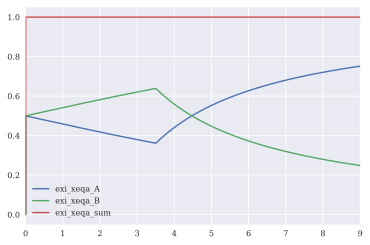

In [48]:
xx[0].density_df.filter(regex='exi_xeqa').plot(xlim=[0,9])

In [4]:
xx = uw('''port Example1
    agg Expon   1 claims sev 1 * expon fixed note{exponential component}
    agg Uniform 1 claims sev 3 * uniform fixed note{uniform component}''')

In [5]:
xx

{ "name": "Example1", 'spec': [{'name': 'Expon', 'note': 'exponential component'}, {'name': 'Uniform', 'note': 'uniform component'}]}

In [6]:
xx.recommend_bucket()

,bs10,bs11,bs12,bs13,bs14,bs15,bs16,bs18,bs20
line,,,,,,,,,
Expon,0.007072,0.003536,0.001768,0.000884,0.000442,0.000221,0.000110,0.000028,0.000007
Uniform,0.004078,0.002039,0.001020,0.000510,0.000255,0.000127,0.000064,0.000016,0.000004
total,0.011150,0.005575,0.002788,0.001394,0.000697,0.000348,0.000174,0.000044,0.000011


In [7]:
xx.update(bs=0.0005, log2=16, add_exa=True, remove_fuzz=True)

In [8]:
xx

,Expon,Uniform,total
"(freq, mean)",1,1,2
"(freq, cv)",0,0,0
"(freq, skew)",NaN,NaN,NaN
"(sev, mean)",1,1.5,1.25
"(sev, cv)",1,0.57735,0.774597
"(sev, skew)",2,-2.73488e-15,0.998369
"(agg, mean)",1,1.5,2.5
"(agg, cv)",1,0.57735,0.52915
"(agg, skew)",2,-2.73488e-15,0.863919
Mean,1,1.5,2.5


In [12]:
a1, a2 = extract_info(xx, 0.995, 0.12)
display(a2)
display(a2.filter(regex='LR', axis=0))

Example1                    
                     basic        ph      wang
var               7.148500  7.148500  7.148500
tvar              8.149000  8.149000  8.149000
r                 0.120000  0.120000  0.120000
distn param            NaN  0.655678  0.443627
S(var)            0.004999  0.004999  0.004999
S(tvar)           0.001838  0.001838  0.001838
Prem(total)       3.103581  3.103608  3.103608
Prem(Uniform)     1.570058  1.676194  1.742200
Prem(Expon)       1.533524  1.427414  1.361408
LR(total)         0.804929  0.804922  0.804922
LR(Uniform)       0.955126  0.894647  0.860752
LR(Expon)         0.651153  0.699558  0.733475
EL(total)         2.498161  2.498161  2.498161
EL(Uniform)       1.499602  1.499602  1.499602
EL(Expon)         0.998559  0.998559  0.998559
E(total|U>var)    8.148750  8.148750  8.148750
E(Uniform|U>var)  2.157187  2.157187  2.157187
E(Expon|U>var)    5.991563  5.991563  5.991563

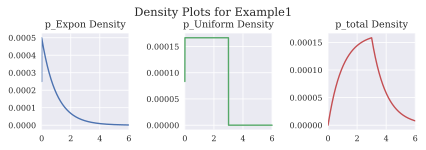

In [13]:
xx.plot(subplots=True, xlim=[0,6])

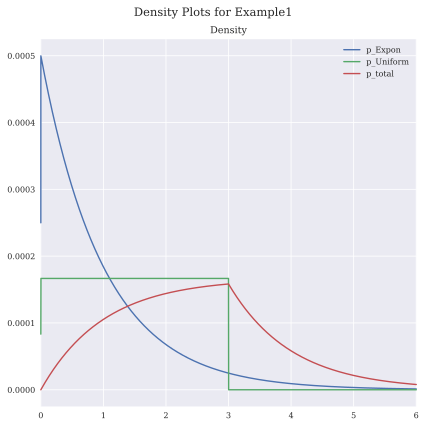

In [14]:
xx.plot(figsize=(6,6), xlim=[0,6])

In [15]:
xx.report('audit')

,Mean,CV,Skew,Limit,P99.9Est,Sum log,EmpMean,EmpCV,EmpSkew,EmpEX1,EmpEX2,EmpEX3,P90.0,P95.0,P99.0,P99.6,P99.9,P99.99,P99.9999,MeanErr,CVErr,SkewErr
Expon,1,1,2,inf,7.24152,1,1,1,2,1,2,6,2.3025,2.9955,4.605,5.5215,6.908,9.2105,13.8155,-1.04285e-08,3.10988e-08,-6.66644e-08
Uniform,1.5,0.57735,-2.73488e-15,inf,4.17622,1,1.5,0.57735,0,1.5,3,6.75,2.7,2.85,2.97,2.988,2.997,2.9995,3,0,2.77778e-08,-1
total,2.5,0.52915,0.863919,inf,8.41348,1,2.5,0.52915,0.863919,2.5,8,30.75,4.153,4.846,6.4555,7.372,8.758,11.0605,15.666,-4.17168e-09,2.78864e-08,-7.59577e-08


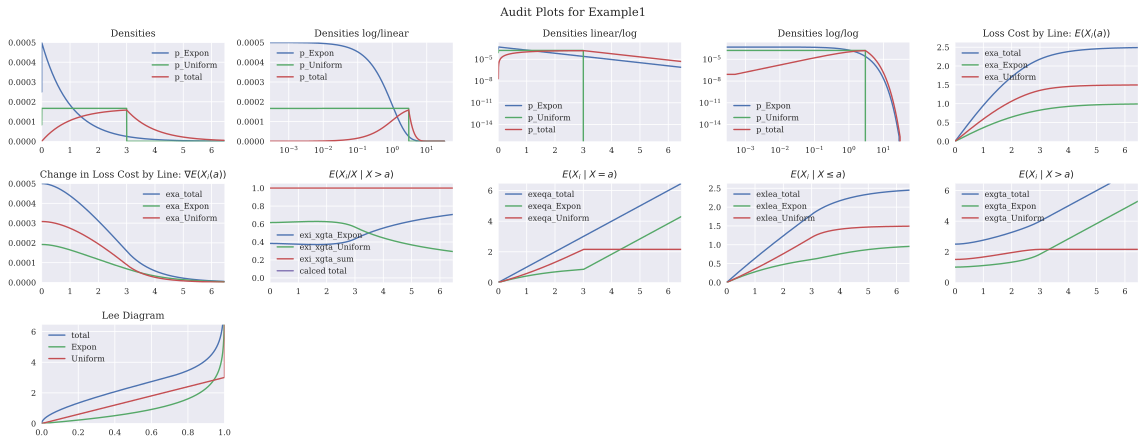

In [16]:
xx.plot('audit', heigh=3, aspect=1.6)

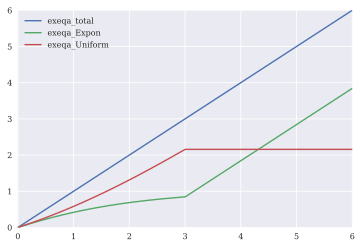

In [17]:
xx.density_df.filter(regex='exeqa_[tEU]').plot(xlim=[0,6], ylim=[0,6])

In [18]:
temp = xx.density_df.filter(regex='exeqa_[tEU]').copy()
temp['Exp'] = temp.exeqa_Expon / temp.exeqa_total
temp['Uni'] = temp.exeqa_Uniform / temp.exeqa_total

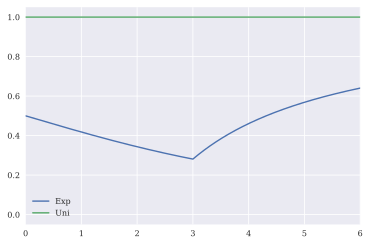

In [19]:
temp.loc[:, ['Exp', 'Uni']].cumsum(axis=1).plot(xlim=[0,6])

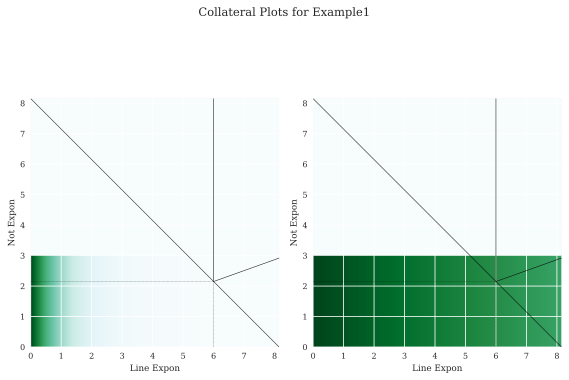

In [94]:
xx.plot(kind='collateral', line='Expon', a=8.149, c=6, figsize=(8,6))

## Replicate Major's Examples and Add Equal Priority View

In [264]:
xx = uw('''port Uniform~Exponential
    agg Expon   1 claims sev 1 * expon fixed note{exponential component}
    agg Uniform 1 claims sev 3 * uniform fixed note{uniform component}''')
xx.update(bs=0.001, log2=14, add_exa=True, remove_fuzz=True)
xx

,Expon,Uniform,total
"(freq, mean)",1,1,2
"(freq, cv)",0,0,0
"(freq, skew)",NaN,NaN,NaN
"(sev, mean)",1,1.5,1.25
"(sev, cv)",1,0.57735,0.774597
"(sev, skew)",2,-2.73488e-15,0.998369
"(agg, mean)",1,1.5,2.5
"(agg, cv)",1,0.57735,0.52915
"(agg, skew)",2,-2.73488e-15,0.863919
Mean,1,1.5,2.5


In [444]:
a1, a2 = extract_info(xx, 0.995, 0.12)
display(a1)
display(a2)

,S,exa_Expon,exa_Uniform,exa_total,exgta_Expon,exgta_Uniform,exgta_total
a,,,,,,,
7.148,0.005001,,,,5.99114,2.1572,8.14693
8.147,0.001841,0.998553,1.4996,2.49816,,,


Uniform Exponential                    
                               basic        ph      wang
var                         7.148000  7.148000  7.148000
tvar                        8.147000  8.147000  8.147000
r                           0.120000  0.120000  0.120000
distn param                      NaN  0.655754  0.443486
S(var)                      0.005001  0.005001  0.005001
S(tvar)                     0.001841  0.001841  0.001841
Prem(total)                 3.103383  3.103390  3.103390
Prem(Uniform)               1.570058  1.676084  1.742126
Prem(Expon)                 1.533472  1.426777  1.361235
LR(total)                   0.804979  0.804977  0.804977
LR(Uniform)                 0.955125  0.894705  0.860788
LR(Expon)                   0.651171  0.699866  0.733564
EL(total)                   2.498157  2.498157  2.498157
EL(Uniform)                 1.499601  1.499601  1.499601
EL(Expon)                   0.998553  0.998553  0.998553
E(total|U>var)              8.146929  8.146929  8.146929
E(Uniform|U>var)            2.157197  2.157197  2.157197
E(Expon|U>var)              5.991138  5.991138  5.991138

In [20]:
display(a2.filter(regex='LR', axis=0))

Example1                    
                basic        ph      wang
LR(total)    0.804929  0.804922  0.804922
LR(Uniform)  0.955126  0.894647  0.860752
LR(Expon)    0.651153  0.699558  0.733475

In [467]:
scenarios = ['''port Uniform~Exponential
    agg expon1   1 claims sev 1 * expon fixed
    agg uniform 1 claims sev 3 * uniform fixed''',
             '''port Exponential~Exponential
    agg expon1   1 claims sev 1 * expon fixed
    agg expon3 1 claims sev 3 * expon fixed''',
             '''port gamma~gamma
    agg gamma25   1 claims sev gamma 1 cv 0.25 fixed
    agg gamma50 1 claims sev gamma 1 cv 0.50 fixed''',
            '''port gamma~lognorm
    agg gamma25   1 claims sev gamma 1 cv 0.25 fixed
    agg lognorm50 1 claims sev lognorm 1 cv 0.50 fixed''',
            '''port lognorm~lognorm
    agg lognorm25   1 claims sev lognorm 1 cv 0.25 fixed
    agg lognorm50 1 claims sev lognorm 1 cv 0.50 fixed''',
            '''port lognorm~thick~lognorm,
    agg lognorm25   1 claims sev lognorm 1 cv 0.25 fixed
    agg lognorm150 1 claims sev lognorm 0.25 cv 1.50 fixed''',
        '''port expon~pareto,
    agg expon1   1 claims sev 1 * expon fixed
    agg pareto15 1 claims sev 1 * pareto 1.5 - 1 fixed''',
        '''port gamma~pareto,
    agg gamma25   1 claims sev gamma 1 cv 0.25 fixed
    agg pareto15 1 claims sev 1 * pareto 1.5 - 1 fixed''',
        '''port lognorm~pareto,
    agg lognorm25   1 claims sev lognorm 1 cv 0.25 fixed
    agg pareto15 1 claims sev 1 * pareto 1.5 - 1 fixed''',
        '''port pareto~pareto,
    agg pareto25   1 claims sev 1 * pareto 2.5 - 1 fixed
    agg pareto15 1 claims sev 1 * pareto 1.5 - 1 fixed''',
        ]

In [476]:
pfs = []
for sc in scenarios:
    xx = uw(sc)
    print(xx.name)
    xx.update(bs=0.0005, log2=20, add_exa=True, padding=1, remove_fuzz=True)
    pfs.append(xx)
#     display(xx)

Uniform~Exponential
Exponential~Exponential
gamma~gamma
gamma~lognorm
lognorm~lognorm
lognorm~thick~lognorm


..\aggregate\utils.py:701: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(var)
C:\Users\steve\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))
C:\Users\steve\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1945: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)


expon~pareto
gamma~pareto
lognorm~pareto
pareto~pareto


In [477]:
a = []
for xx in pfs:
    a1, a2 = extract_info(xx, 0.995, 0.12)
    a.append(a2)

In [478]:
pd.concat(a, axis=1, sort=False).filter(regex='LR', axis=0).fillna('')

Uniform Exponential                      \
                             basic        ph      wang   
LR(total)                 0.804928  0.804935  0.804935   
LR(Uniform)               0.955126  0.894654  0.860761   
LR(Expon)                 0.651153  0.699578  0.733494   
LR(Expon3)                                               
LR(gamma50)                                              
LR(gamma25)                                              
LR(lognorm50)                                            
LR(lognorm25)                                            
LR(lognorm150)                                           
LR(pareto15)                                             
LR(expon1)                                               
LR(pareto25)                                             

               Exponential Exponential                     gamma gamma  \
                                 basic        ph      wang       basic   
LR(total)                      0.69818  0.698183  0.698183    0.895664   
LR(Uniform)                                                              
LR(Expon)                     0.949112  0.888001   0.85034               
LR(Expon3)                     0.64156  0.651683  0.658832               
LR(gamma50)                                                   0.827175   
LR(gamma25)                                                   0.976494   
LR(lognorm50)                                                            
LR(lognorm25)                                                            
LR(lognorm150)                                                           
LR(pareto15)                                                             
LR(expon1)                                                               
LR(pareto25)                                                             

                                   gamma lognorm                      \
                      ph      wang         basic        ph      wang   
LR(total)       0.895674  0.895674      0.877135  0.877154  0.877154   
LR(Uniform)                                                            
LR(Expon)                                                              
LR(Expon3)                                                             
LR(gamma50)     0.835763  0.841494                                     
LR(gamma25)     0.964817  0.957293      0.984394  0.963389  0.949424   
LR(lognorm50)                           0.790907   0.80505  0.815075   
LR(lognorm25)                                                          
LR(lognorm150)                                                         
LR(pareto15)                                                           
LR(expon1)                                                             
LR(pareto25)                                                           

               lognorm lognorm                     lognorm thick lognorm  \
                         basic        ph      wang                 basic   
LR(total)             0.876929  0.876948  0.876948              0.784538   
LR(Uniform)                                                                
LR(Expon)                                                                  
LR(Expon3)                                                                 
LR(gamma50)                                                                
LR(gamma25)                                                                
LR(lognorm50)         0.791665  0.805747    0.8151                         
LR(lognorm25)         0.982706  0.961898  0.948908              0.990424   
LR(lognorm150)                                                  0.426844   
LR(pareto15)                                                               
LR(expon1)                                                                 
LR(pareto25)                                                               

                                   expon pareto                      \
                    

In [472]:
pd.concat(a, axis=1, sort=False).filter(regex='LR', axis=0).fillna('')

Uniform Exponential                      \
                             basic        ph      wang   
LR(total)                 0.804928  0.804935  0.804935   
LR(Uniform)               0.955126  0.894654  0.860761   
LR(Expon)                 0.651153  0.699578  0.733494   
LR(Expon3)                                               
LR(gamma50)                                              
LR(gamma25)                                              
LR(lognorm50)                                            
LR(lognorm25)                                            
LR(lognorm150)                                           
LR(pareto15)                                             
LR(expon1)                                               
LR(pareto25)                                             

               Exponential Exponential                     gamma gamma  \
                                 basic        ph      wang       basic   
LR(total)                      0.69987  0.699871  0.699872    0.895664   
LR(Uniform)                                                              
LR(Expon)                     0.948935  0.888833  0.851124               
LR(Expon3)                    0.642565  0.655265  0.660869               
LR(gamma50)                                                   0.827175   
LR(gamma25)                                                   0.976494   
LR(lognorm50)                                                            
LR(lognorm25)                                                            
LR(lognorm150)                                                           
LR(pareto15)                                                             
LR(expon1)                                                               
LR(pareto25)                                                             

                                   gamma lognorm                      \
                      ph      wang         basic        ph      wang   
LR(total)       0.895674  0.895674      0.877135  0.877154  0.877154   
LR(Uniform)                                                            
LR(Expon)                                                              
LR(Expon3)                                                             
LR(gamma50)     0.835763  0.841494                                     
LR(gamma25)     0.964817  0.957293      0.984394  0.963389  0.949424   
LR(lognorm50)                           0.790907   0.80505  0.815075   
LR(lognorm25)                                                          
LR(lognorm150)                                                         
LR(pareto15)                                                           
LR(expon1)                                                             
LR(pareto25)                                                           

               lognorm lognorm                     lognorm thick lognorm  \
                         basic        ph      wang                 basic   
LR(total)             0.876929  0.876948  0.876948              0.784646   
LR(Uniform)                                                                
LR(Expon)                                                                  
LR(Expon3)                                                                 
LR(gamma50)                                                                
LR(gamma25)                                                                
LR(lognorm50)         0.791665  0.805747    0.8151                         
LR(lognorm25)         0.982706  0.961898  0.948908              0.990423   
LR(lognorm150)                                                  0.426983   
LR(pareto15)                                                               
LR(expon1)                                                                 
LR(pareto25)                                                               

                                   expon pareto                      \
                    

In [ ]:
xx.update

# Pricing Options

In [54]:
base_pf = '''port LNExample{i}
    agg A   1 claims sev {ex1} * lognorm 1 cv 0.25 fixed
    agg B   1 claims sev {ex2} * lognorm 1 cv 0.50 fixed'''
xx = uw(base_pf.format(i=1, ex1=1000, ex2=200))
xx.recommend_bucket()

In [56]:
xx.update(bs=0.05, log2=16, remove_fuzz=True, add_exa=True)

In [148]:
def tvar(xx, p):
    """
    figure var, tvar and tvar closest to index 
    """
    var = xx.q(p)
    tvar = xx.density_df.loc[var, 'exgta_total']
    i = xx.density_df.index.get_loc(tvar, 'nearest')
    tvar0 = xx.density_df.index[i]
    return var, tvar, tvar0

In [270]:
def pricing_report(xx, p, distortion):
    """
    K = tvar(p)
    Figure pricing using distortion
    return reasonable set of stats
    """
    v, t, t0 = tvar(xx, p)
    df, _ = xx.apply_distortion(distortion, None, 0)
    row = df.loc[t0, :]
    # line_filter 
    lf = '|'.join(xx.line_names_ex)
    loss = row.filter(regex=f'exa_({lf})$').sort_index()
    prem = row.filter(regex=f'exag_({lf})$').sort_index()
    derv = pd.Series(row.filter(regex=f'exeqa_({lf})$').sort_index().values / loss.values, index=[f'dq_{i}' for i in xx.line_names_ex])
    s1 = pd.Series([i/j for i, j in zip(loss, prem)], 
                 index=[f'LR_{i}' for i in sorted(xx.line_names_ex)])
    s11 = pd.Series([i / s1.LR_total for i in s1.filter(regex='LR_[^t]')],
                    index = [f'LRR_{i}' for i in sorted(xx.line_names)])
    pr = row.exag_total
    K = t0 - pr
    margin = pr - row.exa_total
    roe = margin / K
    levg = pr / K
    max_error = xx.audit_df.filter(regex='(Mean|CV)Err', axis=1).abs().max().max()
    s2 = pd.Series([v, t, t0, K, margin, roe, levg, row.S, max_error], 
                  index=['var', 'tvar', 'tvar0', 'K', 'margin', 'roe', 'levg', 'pr(default)', 'max error'])
    s3 = df.filter(regex=f'exgta_').loc[v, :].sort_index()
    # ind standard approach 
    s4 = pd.Series([(l + roe * k)/(1+roe) for l, k in zip(loss, s3)], index=[f'exag_{i}_isp' for i in xx.line_names_ex])
    s41 = pd.Series([i/j for i, j in zip(loss, s4)], 
                 index=[f'LR_{i}_isp' for i in sorted(xx.line_names_ex)])
    s42 = pd.Series([i / s1.LR_total for i in s41.filter(regex='LR_[^t]')],
                    index = [f'LRR_{i}_isp' for i in sorted(xx.line_names)])
    return pd.concat((loss, prem, derv, s1, s11, s2, s3, s4, s41, s42)).sort_index()

In [271]:
x = pricing_report(xx, 0.995, agg.Distortion('ph', 0.65))
x

K                 1171.602220
LRR_A                1.095187
LRR_A_isp            1.109732
LRR_B                0.935655
LRR_B_isp            0.878909
LR_A                 0.967688
LR_A_isp             0.980540
LR_B                 0.826729
LR_B_isp             0.776590
LR_total             0.883583
LR_total_isp         0.883584
dq_A                 1.173203
dq_B                 3.049945
dq_total             2.109177
exa_A              599.582934
exa_B              598.295162
exa_total         1198.666871
exag_A             619.603378
exag_A_isp         611.482283
exag_B             723.689755
exag_B_isp         770.413601
exag_total        1356.597780
exag_total_isp    1356.596610
exgta_A            699.756981
exgta_B           2047.265269
exgta_total       2528.190150
levg                 1.157900
margin             157.930909
max error            0.007133
pr(default)          0.003897
roe                  0.134799
tvar              2528.190150
tvar0             2528.200000
var       

In [238]:
def uber(xx, ps, ds):
    """
    make portfolio
    compute stats for different ps and ds
    """
    ans = []
    for p in ps:
        for d in ds:
            s = pricing_report(xx, p, d)
            s['p'] = p
#             s['d'] = str(d).replace("\n", " ")
            s['des'] = f'{repr(d)} @ {p}'
            ans.append(s)
    df = pd.concat(ans, axis=1)
    df = df.rename(columns=df.iloc[-1,:])
#     df = df.T.set_index(('p', 'd')).T
    return df.iloc[:-1, :]

In [266]:
df = uber(xx, [0.95, 0.99, 0.995, 0.999], [agg.Distortion('ph', 0.65)])

In [267]:
df

,ph (0.65) @ 0.95,ph (0.65) @ 0.99,ph (0.65) @ 0.995,ph (0.65) @ 0.999
K,735.742,1082.76,1171.6,777.1
LRR_A,1.08873,1.09418,1.09519,1.08952
LRR_A_isp,1.08627,1.10651,1.11,1.08939
LRR_B,0.937533,0.935824,0.935655,0.937227
LRR_B_isp,0.87086,0.86886,0.869008,0.870375
LR_A,0.974152,0.968429,0.967688,0.973128
LR_A_isp,0.971957,0.979348,0.980779,0.973007
LR_B,0.838871,0.828274,0.826729,0.8371
LR_B_isp,0.779214,0.769007,0.767841,0.777391
LR_total,0.894764,0.885075,0.883583,0.893167


## Example 1

In [311]:
summary = 'K|LRR|dq_[A-Z]|exag|exgta|levg|margin|roe|levg|pr(default)|max error'

,bs10,bs11,bs12,bs13,bs14,bs15,bs16,bs18,bs20
line,,,,,,,,,
A,2.027595,1.013797,0.506899,0.253449,0.126725,0.063362,0.031681,0.007920,0.001980
B,0.752044,0.376022,0.188011,0.094006,0.047003,0.023501,0.011751,0.002938,0.000734
total,2.779639,1.389820,0.694910,0.347455,0.173727,0.086864,0.043432,0.010858,0.002714


,ph (0.65) @ 0.95,ph (0.65) @ 0.99,ph (0.65) @ 0.995,ph (0.65) @ 0.999
K,549.29,801.831,908.952,1151.72
LRR_A,0.996556,0.996451,0.99643,0.996418
LRR_A_isp,0.99624,0.995342,0.995019,0.994177
LRR_B,1.01917,1.01993,1.02013,1.0204
LRR_B_isp,1.01911,1.02357,1.025,1.02734
dq_A,1.57584,1.80806,1.90543,2.1251
dq_B,1.43222,1.57742,1.63533,1.76166
exag_A,1093.88,1104.46,1106.44,1108.62
exag_A_isp,1094.22,1105.69,1108,1111.12
exag_B,213.997,215.824,216.156,216.515


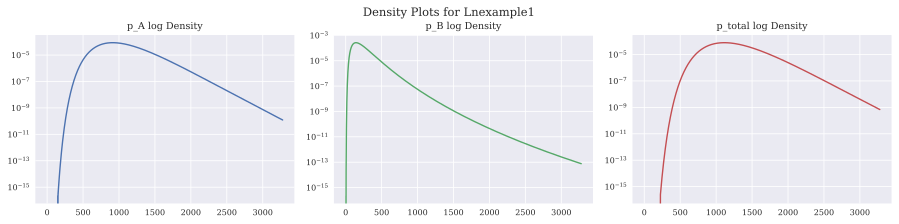

In [301]:
base_pf = '''port LNExample{i}
    agg A   1 claims sev {ex1} * lognorm 1 cv 0.25 fixed
    agg B   1 claims sev {ex2} * lognorm 1 cv 0.50 fixed'''
xx = uw(base_pf.format(i=1, ex1=1000, ex2=200))
display(xx.recommend_bucket())
xx.update(bs=0.05, log2=16, remove_fuzz=True, add_exa=True)
xx.plot(subplots=True, height=3, aspect=1.4, logy=True)
df = uber(xx, [0.95, 0.99, 0.995, 0.999], [agg.Distortion('ph', 0.65)])
display(df.filter(regex=summary, axis=0))

## Example 2

,bs10,bs11,bs12,bs13,bs14,bs15,bs16,bs18,bs20
line,,,,,,,,,
A,1.216557,0.608278,0.304139,0.152070,0.076035,0.038017,0.019009,0.004752,0.001188
B,2.256133,1.128066,0.564033,0.282017,0.141008,0.070504,0.035252,0.008813,0.002203
total,3.472690,1.736345,0.868172,0.434086,0.217043,0.108522,0.054261,0.013565,0.003391


,ph (0.65) @ 0.95,ph (0.65) @ 0.99,ph (0.65) @ 0.995,ph (0.65) @ 0.999
K,758.815,1201.21,1408.14,1926.47
LRR_A,1.08612,1.09179,1.09332,1.09547
LRR_A_isp,1.08779,1.11018,1.11654,1.1263
LRR_B,0.92634,0.922477,0.921428,0.91996
LRR_B_isp,0.925033,0.909614,0.905414,0.899077
dq_A,1.18488,1.17182,1.16403,1.14573
dq_B,2.32523,3.0979,3.45575,4.3446
exag_A,616.612,622.062,623.037,624.082
exag_A_isp,615.664,611.754,610.078,606.999
exag_B,720.005,735.449,738.828,743.036


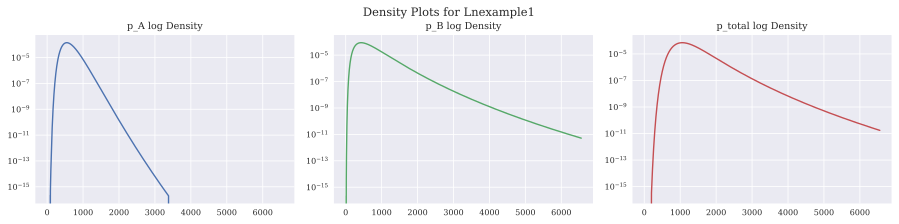

In [300]:
base_pf = '''port LNExample{i}
    agg A   1 claims sev {ex1} * lognorm 1 cv 0.25 fixed
    agg B   1 claims sev {ex2} * lognorm 1 cv 0.50 fixed'''
xx = uw(base_pf.format(i=1, ex1=600, ex2=600))
display(xx.recommend_bucket())
xx.update(bs=0.05, log2=17, remove_fuzz=True, add_exa=True)
xx.plot(subplots=True, height=3, aspect=1.4, logy=True)
df = uber(xx, [0.95, 0.99, 0.995, 0.999], [agg.Distortion('ph', 0.65)])
display(df.filter(regex=summary, axis=0))

,bs10,bs11,bs12,bs13,bs14,bs15,bs16,bs18,bs20
line,,,,,,,,,
A,1.847728,0.923864,0.461932,0.230966,0.115483,0.057741,0.028871,0.007218,0.001804
B,3.760222,1.880111,0.940055,0.470028,0.235014,0.117507,0.058753,0.014688,0.003672
C,2.261894,1.130947,0.565474,0.282737,0.141368,0.070684,0.035342,0.008836,0.002209
total,7.869844,3.934922,1.967461,0.983730,0.491865,0.245933,0.122966,0.030742,0.007685


,ph (0.65) @ 0.95,ph (0.65) @ 0.99,ph (0.65) @ 0.995,ph (0.65) @ 0.999
K,1379.73,2178.14,2555.25,3519.6
LRR_A,1.08198,1.08743,1.0889,1.09101
LRR_A_isp,1.08871,1.11008,1.11595,1.12504
LRR_B,0.94481,0.942266,0.94167,0.941003
LRR_B_isp,0.939214,0.931701,0.931808,0.939144
LRR_C,0.934144,0.928668,0.926801,0.923431
LRR_C_isp,0.935936,0.906042,0.890447,0.843557
dq_A,1.16533,1.15405,1.14843,1.13388
dq_B,2.19521,2.82328,3.09323,3.67822
dq_C,2.16313,2.98762,3.46169,5.06735


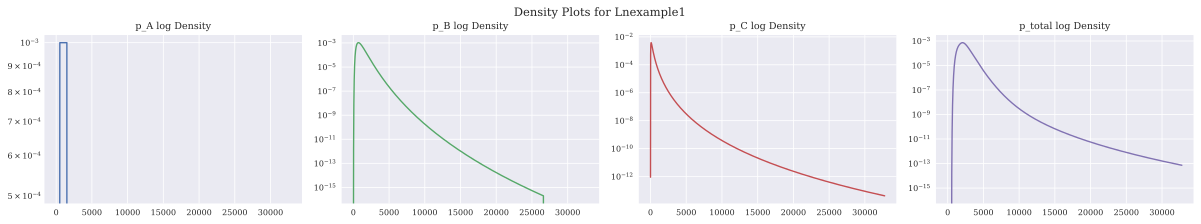

In [312]:
base_pf = '''port LNExample{i}
    agg A   1 claims sev {ex1} * uniform + 500 fixed
    agg B   1 claims sev {ex1} * lognorm 1 cv 0.5 fixed
    agg C   1 claims sev {ex2} * lognorm 1 cv 1.0 fixed'''
xx = uw(base_pf.format(i=1, ex1=1000, ex2=250))
display(xx.recommend_bucket())
xx.update(bs=1, log2=15, remove_fuzz=True, add_exa=True)
xx.plot(subplots=True, height=3, aspect=1.4, logy=True)
df = uber(xx, [0.95, 0.99, 0.995, 0.999], [agg.Distortion('ph', 0.65)])
display(df.filter(regex=summary, axis=0))

,bs10,bs11,bs12,bs13,bs14,bs15,bs16,bs18,bs20
line,,,,,,,,,
A,1.216557,0.608278,0.304139,0.152070,0.076035,0.038017,0.019009,0.004752,0.001188
B,5.428546,2.714273,1.357137,0.678568,0.339284,0.169642,0.084821,0.021205,0.005301
total,6.645103,3.322552,1.661276,0.830638,0.415319,0.207659,0.103830,0.025957,0.006489


,ph (0.65) @ 0.95,ph (0.65) @ 0.99,ph (0.65) @ 0.995,ph (0.65) @ 0.999
K,1669.55,3131.82,3905.34,5986.72
LRR_A,1.21004,1.23859,1.24701,1.25944
LRR_A_isp,1.20756,1.25509,1.2676,1.28503
LRR_B,0.850492,0.839174,0.835936,0.831438
LRR_B_isp,0.8504,0.829581,0.824149,0.81493
dq_A,1.06355,1.04344,1.03787,1.02873
dq_B,4.22996,6.73571,8.04252,11.5383
exag_A,602.005,610.074,611.552,613.134
exag_A_isp,603.245,602.055,601.614,600.924
exag_B,838.191,894.591,908.706,927.466


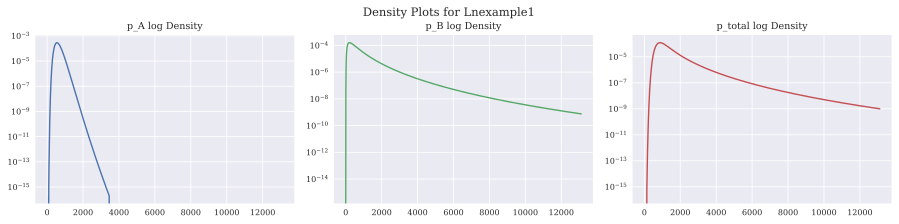

In [304]:
base_pf = '''port LNExample{i}
    agg A   1 claims sev {ex1} * lognorm 1 cv 0.25 fixed
    agg B   1 claims sev {ex2} * lognorm 1 cv 1.00 fixed'''
xx = uw(base_pf.format(i=1, ex1=600, ex2=600))
display(xx.recommend_bucket())
xx.update(bs=0.1, log2=17, remove_fuzz=True, add_exa=True)
xx.plot(subplots=True, height=3, aspect=1.4, logy=True)
df = uber(xx, [0.95, 0.99, 0.995, 0.999], [agg.Distortion('ph', 0.65)])
display(df.filter(regex=summary, axis=0))

..\aggregate\utils.py:701: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(var)
C:\Users\steve\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))
C:\Users\steve\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1945: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)


,bs10,bs11,bs12,bs13,bs14,bs15,bs16,bs18,bs20
line,,,,,,,,,
A,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
B,7.238062,3.619031,1.809515,0.904758,0.452379,0.226189,0.113095,0.028274,0.007068
total,7.238062,3.619031,1.809515,0.904758,0.452379,0.226189,0.113095,0.028274,0.007068


,ph (0.65) @ 0.95,ph (0.65) @ 0.99,ph (0.65) @ 0.995,ph (0.65) @ 0.999
K,3794.75,9244.87,13322.8,28559.8
LRR_A,0.79723,0.738338,0.714689,0.673169
LRR_A_isp,0.760203,0.622008,0.57516,0.518905
LRR_B,1.11618,1.18309,1.21713,1.29146
LRR_B_isp,1.14564,1.35195,1.47656,1.71103
dq_A,7.4145,24.1144,37.3952,81.4681
dq_B,3.83906,3.45658,2.58469,1.31895
exag_A,580.511,733.78,800.293,933.966
exag_A_isp,608.786,871.015,994.438,1211.62
exag_B,1025.3,1064.41,1069.87,1074.64


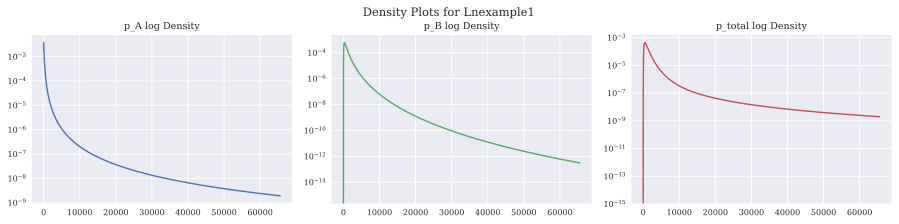

In [313]:
base_pf = '''port LNExample{i}
    agg A   1 claims sev {ex1} * pareto 1.5  - {ex1} fixed
    agg B   1 claims sev {ex2} * lognorm 1 cv 1.00 fixed'''
xx = uw(base_pf.format(i=1, ex1=200, ex2=800))
display(xx.recommend_bucket())
xx.update(bs=0.5, log2=17, remove_fuzz=True, add_exa=True)
xx.plot(subplots=True, height=3, aspect=1.4, logy=True)
df = uber(xx, [0.95, 0.99, 0.995, 0.999], [agg.Distortion('ph', 0.65)])
display(df.filter(regex=summary, axis=0))

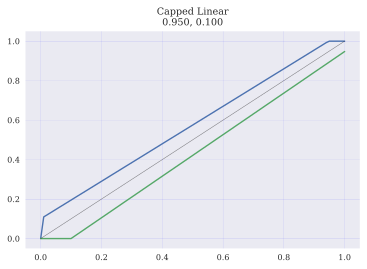

In [332]:
d = agg.Distortion('clin', 0.95, r0=0.1)
d.plot()

In [333]:
def roe(d):
    ps = np.linspace(0,1,101)
    gs = d.g(ps)
    rs = (gs - ps) / (1 - gs)
    plt.plot(ps, gs, label='g')
    plt.plot(ps, rs, label='roe')
    plt.ylim(0,3)
    plt.legend()

C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


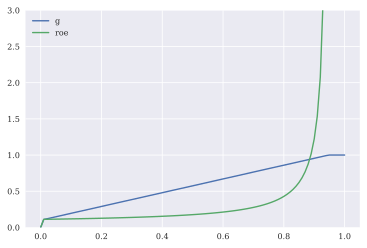

In [334]:
roe(d)

..\aggregate\spectral.py:150: RuntimeWarning: invalid value encountered in sqrt
  rad = np.sqrt(mb * mb - 4 * a * c)
..\aggregate\spectral.py:153: RuntimeWarning: invalid value encountered in maximum
  return np.where(x < d, 0, np.maximum(0, u))


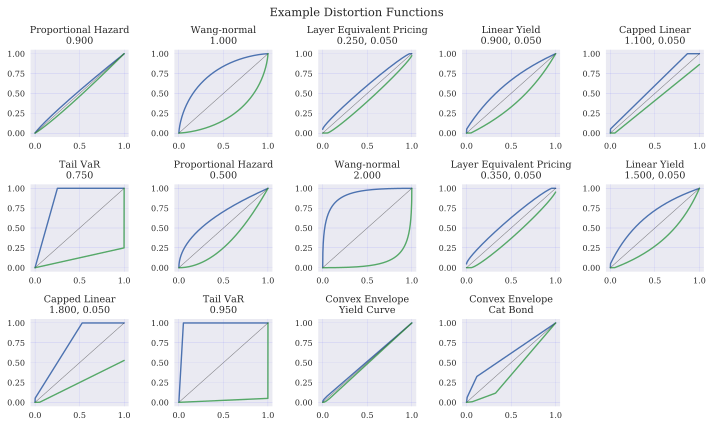

In [321]:
agg.Distortion.test()

In [324]:
agg.Distortion.available_distortions(pricing=False)

('ph', 'wang', 'lep', 'ly', 'clin', 'tvar', 'convex')

,bs10,bs11,bs12,bs13,bs14,bs15,bs16,bs18,bs20
line,,,,,,,,,
A,1.847728,0.923864,0.461932,0.230966,0.115483,0.057741,0.028871,0.007218,0.001804
C,1.816435,0.908217,0.454109,0.227054,0.113527,0.056764,0.028382,0.007095,0.001774
total,3.664163,1.832081,0.916041,0.458020,0.229010,0.114505,0.057253,0.014313,0.003578


,ph (0.65) @ 0.95,ph (0.65) @ 0.99,ph (0.65) @ 0.995,ph (0.65) @ 0.999
K,683.674,1125.96,1360.21,2009.89
LRR_A,1.04473,1.04951,1.05105,1.05351
LRR_A_isp,1.06113,1.09311,1.10252,1.11716
LRR_C,0.852698,0.840887,0.837084,0.831079
LRR_C_isp,0.811261,0.745329,0.728617,0.704332
LR_A,0.938875,0.93273,0.931389,0.929798
LR_A_isp,0.953612,0.97148,0.977,0.985979
LR_C,0.766301,0.747324,0.741782,0.733489
LR_C_isp,0.729062,0.662398,0.645664,0.621625
LR_total,0.898678,0.888733,0.886149,0.882574


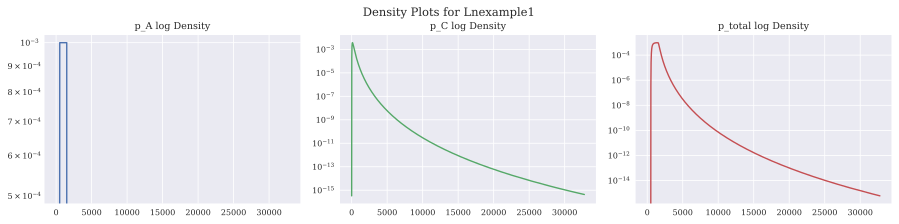

In [341]:
summary = '.'
base_pf = '''port LNExample{i}
    agg A   1 claims sev {ex1} * uniform + 500 fixed
    agg C   1 claims sev {ex2} * lognorm 1 cv 0.85 fixed'''
xx = uw(base_pf.format(i=1, ex1=1000, ex2=250))
display(xx.recommend_bucket())
xx.update(bs=1, log2=15, remove_fuzz=True, add_exa=True)
xx.plot(subplots=True, height=3, aspect=1.4, logy=True)
df = uber(xx, [0.95, 0.99, 0.995, 0.999], [agg.Distortion('ph', 0.65)])
display(df.filter(regex=summary, axis=0))

,bs10,bs11,bs12,bs13,bs14,bs15,bs16,bs18,bs20
line,,,,,,,,,
A,1.847728,0.923864,0.461932,0.230966,0.115483,0.057741,0.028871,0.007218,0.001804
total,1.847728,0.923864,0.461932,0.230966,0.115483,0.057741,0.028871,0.007218,0.001804


..\aggregate\port.py:1163: RuntimeWarning: invalid value encountered in maximum
  np.maximum(0, (self.density_df.loc[:, 'e_' + col] - self.density_df.loc[:, 'exa_' + col])) / \
..\aggregate\port.py:1167: RuntimeWarning: invalid value encountered in maximum
  self.density_df.loc[:, 'exa_ημ_' + col])) / \


,ph (0.65) @ 0.95,ph (0.65) @ 0.99,ph (0.65) @ 0.995,ph (0.65) @ 0.999
K,370.317,389.036,390.981,392.946
LRR_A,1,1,1,1
LRR_A_isp,1.00005,1.00005,0.999947,0.999936
dq_A,1.47546,1.49502,1.49701,1.499
exag_A,1104.68,1105.96,1106.02,1106.05
exag_A_isp,1104.63,1105.91,1106.08,1106.12
exag_total,1104.68,1105.96,1106.02,1106.05
exag_total_isp,1104.63,1105.91,1106.08,1106.12
exgta_A,1474.75,1494.76,1497.27,1499.33
exgta_total,1474.75,1494.76,1497.27,1499.33


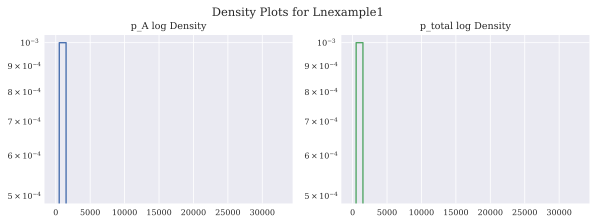

In [340]:
base_pf = '''port LNExample{i}
    agg A   1 claims sev {ex1} * uniform + 500 fixed'''
xx = uw(base_pf.format(i=1, ex1=1000))
display(xx.recommend_bucket())
xx.update(bs=1, log2=15, remove_fuzz=True, add_exa=True)
xx.plot(subplots=True, height=3, aspect=1.4, logy=True)
df = uber(xx, [0.95, 0.99, 0.995, 0.999], [agg.Distortion('ph', 0.65)])
display(df.filter(regex=summary, axis=0))

In [455]:
base_pf = '''port Thick~THin~{i}
    agg Thin   1 claims sev {ex1} * lognorm 1 cv 0.15 fixed
    agg Thick   1 claims sev {ex2} * pareto 1.25 - {ex2} fixed'''
xx = uw(base_pf.format(i=1, ex1=1000, ex2=10))
display(xx.recommend_bucket())
xx.update(bs=1, log2=16, remove_fuzz=True, add_exa=True)
xx

..\aggregate\utils.py:701: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(var)
C:\Users\steve\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))
C:\Users\steve\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1945: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)


,bs10,bs11,bs12,bs13,bs14,bs15,bs16,bs18,bs20
line,,,,,,,,,
Thin,1.5313,0.76565,0.382825,0.191412,0.095706,0.047853,0.023927,0.005982,0.001495
Thick,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
total,1.5313,0.76565,0.382825,0.191412,0.095706,0.047853,0.023927,0.005982,0.001495


,Thick,Thin,total
"(freq, mean)",1,1,2
"(freq, cv)",0,0,0
"(freq, skew)",NaN,NaN,NaN
"(sev, mean)",40,1000,520
"(sev, cv)",NaN,0.15,0.942733
"(sev, skew)",NaN,0.453375,0.161468
"(agg, mean)",40,1000,1040
"(agg, cv)",NaN,0.15,0.135414
"(agg, skew)",NaN,0.453375,0.646021
Mean,40,1000,1040


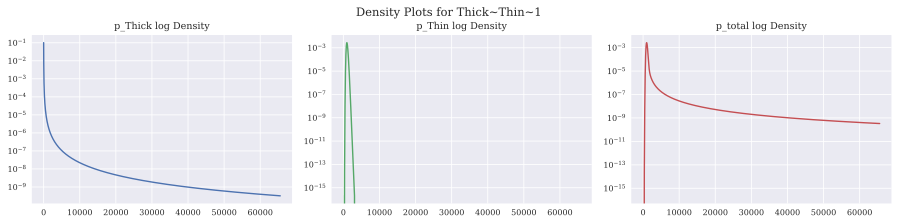

In [457]:
xx.plot(subplots=True, height=3, aspect=1.4, logy=True)

In [458]:
df = uber(xx, [0.95, 0.99, 0.995, 0.999], [agg.Distortion('ph', 0.65)])
display(df.filter(regex=summary, axis=0))

,ph (0.65) @ 0.95,ph (0.65) @ 0.99,ph (0.65) @ 0.995,ph (0.65) @ 0.999
K,506.687,1365,2233.65,6850.84
LRR_Thick,0.457919,0.40384,0.373926,0.308586
LRR_Thick_isp,0.443738,0.286327,0.251758,0.2175
LRR_Thin,1.03361,1.04523,1.05342,1.07828
LRR_Thin_isp,1.03546,1.0784,1.09833,1.13059
LR_Thick,0.426781,0.370193,0.339451,0.272879
LR_Thick_isp,0.413564,0.26247,0.228547,0.192332
LR_Thin,0.963325,0.958143,0.956295,0.95351
LR_Thin_isp,0.965053,0.98855,0.997064,0.999767
LR_total,0.932,0.916682,0.907803,0.884288


In [366]:
[ re.sub(r'([a-z]+|)', dict(), 'steve 100 b Fellow 12')

Index(['K', 'LRR_S', 'LRR_S_isp', 'LRR_T', 'LRR_T_isp', 'LR_S', 'LR_S_isp',
       'LR_T', 'LR_T_isp', 'LR_total', 'LR_total_isp', 'dq_S', 'dq_T',
       'dq_total', 'exa_S', 'exa_T', 'exa_total', 'exag_S', 'exag_S_isp',
       'exag_T', 'exag_T_isp', 'exag_total', 'exag_total_isp', 'exgta_S',
       'exgta_T', 'exgta_total', 'levg', 'margin', 'max error', 'pr(default)',
       'roe', 'tvar', 'tvar0', 'var', 'p'],
      dtype='object')

In [459]:
s = '''LRR\tLoss Ratio Relativity
LR\tLoss Ratio
isp\tIndusty Standard
dq\tPartial Domething
total\tTotal
exgta\tE(X_i | X > a)
exag\tE_g(X(a))
exa\tE(X(a))
_\t 
K\tCapital'''

s1 = { i: j for i, j in [i.split('\t') for i in s.split('\n')]}
pat = r'(' + '|'.join(s1.keys()) + ")"
def f(x):
    m = x.group()
    return s1.get(m, m)     
r = re.compile(pat)

def col_namer(df):
    df.index = [r.sub(f, i) for i in df.index]
    return df.sort_index()

In [460]:
col_namer(df)
df

,ph (0.65) @ 0.95,ph (0.65) @ 0.99,ph (0.65) @ 0.995,ph (0.65) @ 0.999
Capital,506.687,1365,2233.65,6850.84
Loss Ratio Relativity Thick,0.457919,0.40384,0.373926,0.308586
Loss Ratio Relativity Thick Industy Standard,0.443738,0.286327,0.251758,0.2175
Loss Ratio Relativity Thin,1.03361,1.04523,1.05342,1.07828
Loss Ratio Relativity Thin Industy Standard,1.03546,1.0784,1.09833,1.13059
Loss Ratio Thick,0.426781,0.370193,0.339451,0.272879
Loss Ratio Thick Industy Standard,0.413564,0.26247,0.228547,0.192332
Loss Ratio Thin,0.963325,0.958143,0.956295,0.95351
Loss Ratio Thin Industy Standard,0.965053,0.98855,0.997064,0.999767
Loss Ratio Total,0.932,0.916682,0.907803,0.884288


In [388]:
def f(x):
    m = x.group()
    mapper = {'K': "Capital", 
              'LRR_S' : "Loss Ratio Rel for S", 
              'LRR_S_isp' : "Std Method Loss Ratio Rel for S", 'LRR_T', 'LRR_T_isp', 
              'LR_S' : 'Loss Ratio S', 'LR_S_isp',
       'LR_T', 'LR_T_isp', 'LR_total', 'LR_total_isp', 'dq_S', 'dq_T',
       'dq_total', 'exa_S', 'exa_T', 'exa_total', 'exag_S', 'exag_S_isp',
       'exag_T', 'exag_T_isp', 'exag_total', 'exag_total_isp', 'exgta_S',
       'exgta_T', 'exgta_total', 'levg', 'margin', 'max error', 'pr(default)',
       'roe', 'tvar', 'tvar0', 'var', 'p'}
    return mapper[m]

# Thick and Thin Example


In [7]:
base_pf = '''port Thick~Thin~{i}
    agg Thin   1 claims sev {ex1} * lognorm 1 cv 0.15 fixed
    agg Thick 0.5 claims sev {ex2} * pareto 2.25 - {ex2} poisson'''
xx = uw(base_pf.format(i=1, ex1=16000, ex2=1000))
display(xx.recommend_bucket())
xx.update(bs=1, log2=16, add_exa=True, remove_fuzz=True, padding=2)

,bs10,bs11,bs12,bs13,bs14,bs15,bs16,bs18,bs20
line,,,,,,,,,
Thin,24.500797,12.250399,6.125199,3.062600,1.531300,0.765650,0.382825,0.095706,0.023927
Thick,18.111091,9.055546,4.527773,2.263886,1.131943,0.565972,0.282986,0.070746,0.017687
total,42.611888,21.305944,10.652972,5.326486,2.663243,1.331622,0.665811,0.166453,0.041613


,Thick,Thin,total
"(freq, mean)",0.5,1,1.5
"(freq, cv)",1.41421,0,0.471405
"(freq, skew)",1.41421,NaN,1.41421
"(sev, mean)",800,16000,10933.3
"(sev, cv)",3,0.15,0.691153
"(sev, skew)",118.268,0.453375,0.669815
"(agg, mean)",400,16000,16400
"(agg, cv)",4.47214,0.15,0.18252
"(agg, skew)",144.058,0.453375,30.9806
Mean,400,16000,16400


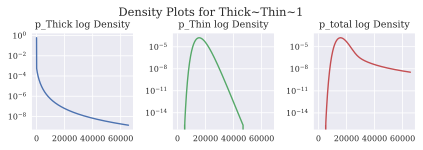

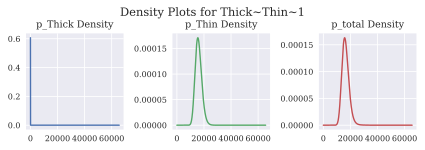

In [8]:
xx.plot(subplots=True, logy=True)
xx.plot(subplots=True)
xx

In [9]:
xx.analysis_priority(0.01, 'df').style

In [64]:
xx.density_df.loc[:, 'epd'] =  (xx.density_df.exgta_total - xx.density_df.loss) * xx.density_df.S

In [69]:
xx.density_df.query(' epd > 163.9 and epd < 164').T

,20010.0,20011.0
loss,2.001000e+04,2.001100e+04
p_Thin,3.873492e-05,3.871257e-05
p_Thick,6.108546e-08,6.107580e-08
p_total,4.791859e-05,4.789465e-05
ημ_Thin,6.108546e-08,6.107580e-08
ημ_Thick,3.873492e-05,3.871257e-05
F,9.140873e-01,9.141352e-01
S,8.591266e-02,8.586477e-02
exa_total,1.622872e+04,1.622881e+04
lev_total,1.622872e+04,1.622881e+04


In [56]:
xx.density_df.exgta_total.loc[19000:19010]

19000.0    20890.496807
19001.0    20891.471764
19002.0    20892.446804
19003.0    20893.421924
19004.0    20894.397126
19005.0    20895.372409
19006.0    20896.347773
19007.0    20897.323219
19008.0    20898.298746
19009.0    20899.274355
19010.0    20900.250045
Name: exgta_total, dtype: float64

In [11]:
df = xx.analysis_priority(dict(Thick=21000), 'df')
df.style

In [13]:
xx.analysis_priority(dict(Thick=21000, Thin=21000), 'html')

C:\Users\steve\Anaconda3\envs\Working_Duplicate\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
C:\Users\steve\Anaconda3\envs\Working_Duplicate\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


(0, 1)

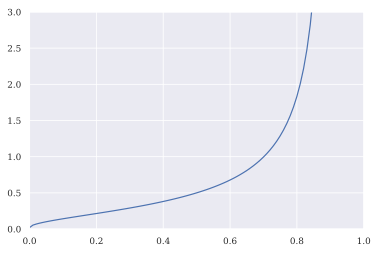

In [13]:
# the LEP distortion function 
i = 0.02
d = i / (1 + i)
rho = 0.5
delta = rho / (1 + rho)
ps = np.linspace(0,1,101)
g = lambda s : s + d*(1-s) + (delta - d)*np.sqrt(s * (1-s))
gps = g(ps)
gps = np.minimum(gps, 1)
roe = (gps - ps) / (1 - gps)
plt.plot(ps, roe)
plt.ylim(0,3)
plt.xlim(0,1)

In [15]:
gps[:10]

array([0.01960784, 0.06062706, 0.08313725, 0.10253717, 0.12030092,
       0.13700234, 0.15293705, 0.16828142, 0.18315081, 0.19762565])